# Milestone 3

### Abstarct

The majority of plots follow one of a few well-known plot arcs in the film industry. Consider a story in which the main character begins in turmoil and ends in happiness, or in which the main character lives blissfully but encounters challenges that must be addressed before returning to his/her delight. In this research, we propose to investigate this phenomena in order to determine the most popular narratives, how lucrative certain storylines are, and how the most prevalent storyline evolves over time. Accordingly, in order to asses this phenomena, we will first construct the various movie arcs from the movie plots. We propose splitting the movie plots into sentences and performing sentiment analysis on every sentence. With that, we can generate for every movie present in the CMU Movie Corpus dataset it's corresponding story arcs. Performing such analysis provides us with rich information on the various emotions present in the movies and how such emotions evolves over the course of the movie.

### Part 1: Getting familiar with the data and constructing the Story Arcs

In this section, we will construct the data pre-processing pipeline for our project. Specifically, we will explore the CMU Movie Corpus dataset by constructing the plot summary data frame and the movie meta data dataframe. 

We will then follow by splitting the movie plot into sentances and perform sentiment analysis on each sentance. With that, we will construct two columns called plot scores and plot classification. The plot scores column contains the list of continuous sentiment scores ranging from (-1: negative) to (+1: positive) while the plot classification column contains the list of sentiment classes taking 3 discrete values (-1: negative), (0: neutral) and (1: positive). 

After performing the previous steps, we can join the two datasets (plot summary, movie meta data) by the wikipedia movie ID. We will then follow by contrsucting 4 different dataframes for the 4 most common genres (Action, Adventure, Comedy and Drama). Now since a movie can have multiple genres, we will make sure that the in constructed dataframes, a movie contain at most one of the four different genres listed. 

Finally, we now have all the needed information to perform clustering on the sentiment time series and with that, we will identify the most common story emotional arcs for each genre. A story emotional arc refers to the plot of the sentiment values over the course of the plot lines which resembles a proxy to the type of events happining in the movies. In a nutshell, this resembles the data-processing pipeline that takes as input the CMU Movie Coprus dataset and outputs the sentiment scores and story emotional arcs of the various movies that we are given.  

#### Part 1.1: Plot Summary dataset (pre-processing + sentiment retrieval)

In [ ]:
# Install the necessary libraries
%pip install nltk
%pip install vaderSentiment
%pip install tslearn

In [1]:
#Imports that are needed for the project
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tslearn.clustering import KernelKMeans, TimeSeriesKMeans, silhouette_score
from collections import defaultdict
from tslearn.utils import to_time_series_dataset
from tslearn.barycenters import softdtw_barycenter
from scipy.signal import savgol_filter
import pandas as pd
from nltk import tokenize
import matplotlib.pyplot as plt
from typing import Dict
import json
import numpy as np
import seaborn as sns
import pickle
from scipy import stats
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")


In order to start with our analysis, we will read the plot_summaries dataset and store it in a dataframe. The dataset plot_summaries contains the plot description of the associated movies and we will use those plots to construct the story arcs.

In [2]:
# Read the Movie Summary Dataset
df_plots = pd.read_csv('MovieSummaries/plot_summaries.txt', sep = '\t', header=None, names = ['id', 'plot'])

# Display the first 5 elements of the dataframe
df_plots.head(5)

,id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Now that we have the movie plots, we need to pre-process them by performing sentance tokenization (splitting the plot into a list of sentances).

In [3]:
#Tranform plots into arrays of sentences using the ntlk library
df_plots['plot_sentances']= df_plots['plot'].apply(lambda t: tokenize.sent_tokenize(t))
df_plots.head(2)

,id,plot,plot_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh..."
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...


Accordingly, now that we have the list of sentances stored in the df_plot dataframe, we can perform sentiment analysis using the Vader Sentiment Analyzer tool. With that given, we will create 2 columns, one storing the continuous sentiment score of each sentance and the other storing the discrete sentiment class negative (-1), neutral (0) and positive (+1) for each sentance.

In [4]:
# instantiate the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# classify the sentiment into one of 3 classes (positive, negative, neutral)
def classify(compound: float):
    if compound >= 0.1:
        #positive
        return 1
    elif compound <= -0.1:
        #negative
        return -1
    #neutral
    return 0

# given a list of sentances, return the result of the analyzer
def analyse_text(paragraph, classify_discrete = True): 
    res = []
    for sentence in paragraph:
        sentiment_result = analyzer.polarity_scores(sentence)
        if classify_discrete:
            res.append(classify(sentiment_result['compound']))
        else:
            res.append(sentiment_result['compound'])
    
    window = int(len(res)/6)
    window = window + 1 if window%2 == 0 else window 
    
    # we utilize a savgol filter, which will smooth the time series (without filtering the resultant time series might be noisy.)
    return savgol_filter(res, window_length=window, polyorder=3) if (not classify_discrete and window>3) else res

In [5]:
# Compute the plot sentitiment discrete classes and continuous scores (the two different columns described previously)
df_plots["plot_classification"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t))
df_plots["plot_scores"] = df_plots["plot_sentances"].apply(lambda t: analyse_text(t, classify_discrete=False))
df_plots["number_of_sentances"] = df_plots["plot_sentances"].apply(lambda t: len(t))

In [6]:
# display the first 5 elements to view the newly added columns 
df_plots.head(5)

,id,plot,plot_sentances,plot_classification,plot_scores,number_of_sentances
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Shlykov, a hard-working taxi driver and Lyosh...",[0],[0.0083],1
1,31186339,The nation of Panem consists of a wealthy Capi...,[The nation of Panem consists of a wealthy Cap...,"[0, -1, 1, 0, 0, -1, -1, 1, 1, 1, 0, -1, -1, 0...","[-0.22422929292929272, 0.01196919191919163, 0....",52
2,20663735,Poovalli Induchoodan is sentenced for six yea...,[Poovalli Induchoodan is sentenced for six ye...,"[-1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 0, -1, -1...","[-0.8036999999999926, 0.34680000000000144, 0.0...",26
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[The Lemon Drop Kid , a New York City swindler...","[-1, 1, 1, -1, -1, 0, 0, 1, -1, -1, 1, 0, -1, ...","[-0.08758181818181772, -0.2674106060606062, -0...",49
4,595909,Seventh-day Adventist Church pastor Michael Ch...,[Seventh-day Adventist Church pastor Michael C...,"[1, 0, 1, -1, 1, 0, -1, 1, -1, -1, -1, 1, -1, ...","[0.4019, 0.0772, 0.2732, -0.6367, 0.4215, 0.0,...",15


#### Part 1.2: Movie Metadata dataset (pre-processing + merging)

Now that we have computed the sentiment scores (story arcs) of the movies present in the plot_summaries (CMU dataset), we will comibine the existing processed data with the movies metadata to have access to more information such as the release date, box office revenue, genres, languages and runtime. 

In [7]:
# read the movie meta-data dataset
df_metadatas = pd.read_csv('MovieSummaries/movie.metadata.tsv',sep='\t', names=["id", "FreebaseId", "Title", "release date", "boxOffice", "Runtime", "language", "country", "genres"])
df_metadatas.head(5)

,id,FreebaseId,Title,release date,boxOffice,Runtime,language,country,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
# Merge the two dataframes based on the Movie Wikipedia ID
processed_df = df_metadatas.merge(df_plots, left_on="id", right_on='id')[['id', 'plot', 'release date', 'Title', 'boxOffice', 'plot_classification', 'plot_scores', "country", "genres", "number_of_sentances", "language", "Runtime"]]
processed_df.head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime
0,975900,"Set in the second half of the 22nd century, th...",2001-08-24,Ghosts of Mars,14010832.0,"[1, 1, -1, -1, 1, 0, -1, -1, -1, 0, 1, -1, -1,...","[0.2235, 0.144, -0.5423, -0.296, 0.25, 0.0, -0...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",15,"{""/m/02h40lc"": ""English Language""}",98.0
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333406, 0.3856095238095242, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0
2,261236,"Eva, an upper class housewife, becomes frustra...",1983,A Woman in Flames,NaN,"[-1, 0, 0, 1, 0, 0, 0, 1, -1, 1, 1, -1, -1, -1...","[-0.7030200000000022, -0.2479199999999998, 0.3...","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",24,"{""/m/04306rv"": ""German Language""}",106.0
3,18998739,"Every hundred years, the evil Morgana returns...",2002,The Sorcerer's Apprentice,NaN,"[-1, -1, 0, 1, 1, -1, -1]","[-0.836, -0.5106, 0.0, 0.6486, 0.3182, -0.3612...","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...",7,"{""/m/02h40lc"": ""English Language""}",86.0
4,6631279,"Adam, a San Francisco-based artist who works a...",1997-04-04,Little city,NaN,"[0, -1, 1, 0, -1, -1, 0, 0, -1]","[-0.0258, -0.3612, 0.6705, 0.0, -0.4404, -0.12...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",9,"{""/m/02h40lc"": ""English Language""}",93.0


In [9]:
# count the number of movies that we already have in the dataset after the merge 
initial_size_of_the_dataset = len(processed_df)
print(f"The initial size of the dataset : {initial_size_of_the_dataset}")

# remove the movies that have plot sentances lower than 5
processed_df = processed_df[processed_df["number_of_sentances"]>5]
size_of_the_dataset = len(processed_df)
print(f"The size of the dataset after removing movies that have plot sentances less than 5: {size_of_the_dataset}")

# drop the rows that have no box office revenues (we are interrested in the profitability of story arcs; only for the profitability study) 
boxoffice_df = processed_df.dropna(subset=["boxOffice"])
size_of_the_dataset = len(boxoffice_df)
print(f"The size of the dataset after removing movies that have no revenue values: {size_of_the_dataset}")



The initial size of the dataset : 42204
The size of the dataset after removing movies that have plot sentances less than 5: 28033
The size of the dataset after removing movies that have no revenue values: 6450


In [ ]:
# pre-process countries, genres, and languages column ["optional"]

def get_unique_elements(feature):
    # this function takes as input the feature column and return a list of all the unique elements in the list
    feature_vector = []
    for sample in feature:
        feature_vector.extend(json.loads(sample).values())

    return list(set(feature_vector))

unique_country_vector = get_unique_elements(processed_df["country"].values)
unique_langauge_vector = get_unique_elements(processed_df["language"].values)
unique_genres_vector = get_unique_elements(processed_df["genres"].values)

def get_feature_vector(sample, unique_vector):
    feature = [0]*len(unique_vector)
    list_of_features_present = list(json.loads(sample).values())
    for feature_name in list_of_features_present:
        feature[unique_vector.index(feature_name)]+=1
    return feature
    
processed_df["bag_of_countries"] = processed_df["country"].apply(lambda sample: get_feature_vector(sample, unique_country_vector))
processed_df["bag_of_langauges"] = processed_df["language"].apply(lambda sample: get_feature_vector(sample, unique_langauge_vector))
processed_df["bag_of_genres"] = processed_df["genres"].apply(lambda sample: get_feature_vector(sample, unique_genres_vector))

processed_df.head()

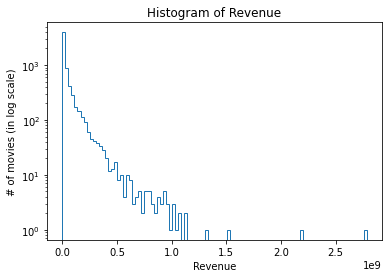

In [10]:
# let us plot the distribution of the box office revenue of different movies
plt.hist(boxoffice_df['boxOffice'],bins=100,log=True,histtype='step')
plt.title('Histogram of Revenue')
plt.ylabel('# of movies (in log scale)')
plt.xlabel('Revenue')
plt.show()

Now since the movie arcs are highly dependant on the genre, we will divide our dataset into 4 different data frames where each data frame contain only the genre that we are interrested in. Yet movies, tend not to belong to only one genre but to multiple genres. Accordingly, we splitted the dataset in a mutually exclusive manner. Specifically, when we are constructing a dataframe of a genre of interest, we made sure that the choosen movies does not share any other genre of interest besides the constructed one. 

In [11]:
genres_of_interest =  ["adventure", "drama", "comedy", "action", "thriller", "science fiction", "costume adventure", "romance comedy"]

# In this part, we create different dataframes for the most common genres (1. Adventure, 2. Action, 3. Drama, 4. Comedy)
def is_needed_genre(genre_movie: Dict[str, str],genres_to_match: str):
        # get list of genres present in the movie
        list_of_genres_in_movie = list(genre_movie.values())

        # get list of genres to discard to avoid duplicates
        genres_to_discard = [genre for genre in genres_of_interest if genre not in genres_to_match]
        
        # flags to be used
        contains_needed_genre = False
        contains_not_needed_genres = False
        
        # iterate over all genres present in the movies
        for genre in list_of_genres_in_movie:
            # check if there is a match
            if (genre.lower() in genres_to_match):
                contains_needed_genre = True
            
            if (genre.lower() in genres_to_discard):
                contains_not_needed_genres = True
        
        # return True only if meets the following criteria
        return (contains_needed_genre) and (not contains_not_needed_genres)

# construct the 4 different datasets 
processed_df["action"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["action", "thriller"]))
processed_df["adventure"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["adventure", "science fiction", "costume adventure"]))
processed_df["drama"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["drama"]))
processed_df["comedy"] = processed_df['genres'].apply(lambda genres: is_needed_genre(json.loads(genres), ["comedy", "romance comedy"]))

In [12]:
# create the action dataframe
action_df = processed_df[processed_df["action"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the adventure dataframe
adventure_df = processed_df[processed_df["adventure"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the drama dataframe
drama_df = processed_df[processed_df["drama"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

# create the comedy dataframe
comedy_df = processed_df[processed_df["comedy"]].copy().drop(["action", "comedy", "drama", "adventure"], axis=1)

In [41]:
# form the dataset loader
dataset_by_genre = {"Action": action_df.copy(), "Adventure": adventure_df.copy(), "Drama":drama_df.copy(), "Comedy":comedy_df.copy()}

In [42]:
# Let us visualize the size of the constructed dataset
print(f"The size of the action dataset is {len(action_df)}")
print(f"The size of the adventure dataset is {len(adventure_df)}")
print(f"The size of the drama dataset is {len(drama_df)}")
print(f"The size of the comedy dataset is {len(comedy_df)}")

The size of the action dataset is 2374
The size of the adventure dataset is 1019
The size of the drama dataset is 7409
The size of the comedy dataset is 3790


Now that we have the different dataframes, we can visualize a randomly choosen story arc of a movie for each genre.

Text(0.04, 0.5, 'Sentiment Value')

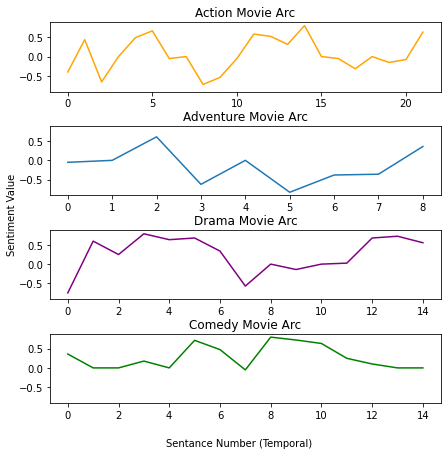

In [43]:
# now let us visualize different movie arcs for each genre (a sample from each)
fig, axis = plt.subplots(4, figsize=(7,7), sharey=True)
# plot the random adventure movie arc
axis[0].plot(list(action_df.iloc[11]["plot_scores"]), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(list(adventure_df.iloc[10]["plot_scores"]))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(list(drama_df.iloc[5]["plot_scores"]), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(list(comedy_df.iloc[20]["plot_scores"]), color="green")
axis[3].set_title("Comedy Movie Arc")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

Visualizing one movie is often noisy and not representative, accordingly, we will find the average sentiment score for all the movies in each genre. With that, we compute the typical movie story arc by taking into account the fact that different movies have different lengths. 

This is done using the tslearn library which contains an effective way in computing the typical (bayercenter) of the time series of various lengths. As can be seen in the figure below, the sentiment at the end of the movie changes abruptly for the different clusters (typical behavior in the movie industry)

In [ ]:
def form_features(series_frame: pd.Series):
    dictionary = series_frame.to_dict()
    list_values = [list(emotional_arc) for emotional_arc in dictionary.values() if len(list(emotional_arc))>2]
    return to_time_series_dataset(list_values)

def get_most_common_movie_arc_using_softdtw(series_frame):
    centers =  softdtw_barycenter(form_features(series_frame))  
    return centers

In [ ]:
# Averaging using tslearn library
# Visualize the most common movie arc in each genre (by taking average of all the datapoints)

fig, axis = plt.subplots(5, figsize=(7,10), sharey=True)

axis[0].plot(get_most_common_movie_arc_using_softdtw(action_df["plot_scores"]), color="orange")
axis[0].set_title("Action Movie Arc")

axis[1].plot(get_most_common_movie_arc_using_softdtw(adventure_df["plot_scores"]))
axis[1].set_title("Adventure Movie Arc")

axis[2].plot(get_most_common_movie_arc_using_softdtw(drama_df["plot_scores"]), color="purple")
axis[2].set_title("Drama Movie Arc")

axis[3].plot(get_most_common_movie_arc_using_softdtw(comedy_df["plot_scores"]), color="green")
axis[3].set_title("Comedy Movie Arc")

axis[4].plot(get_most_common_movie_arc_using_softdtw(processed_df["plot_scores"]), color="gray")
axis[4].set_title("Common Movie Arc (all genres)")

fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.04, "Sentance Number (Temporal)", ha="center")
fig.text(0.04, 0.5, "Sentiment Value", va="center", rotation="vertical")

#### Part 1.3: Clustering Analysis of the Story Arcs

Now that, we have a rough idea about the most representative story arc of each genre, we will cluster the different time series (sentiment scores per plot). In our analysis, we have presented two different features to represent the time series (1) using continuous values ranging from -1 to 1 and (2) using discrete classes (-1, 0 and 1). In order to find the optimal (1) feature type and the optimal (2) number of clusters, we will perform a detailed clustering analysis with Silhoutte score as a metric. 

Specifically, Tslearn library proposes two different clustering algorithms (Kernal Kmeans and TimeSeries Kmeans) and two multiple distance (closness) metrics in the TimeSeries Kmeans. With that, we performed a grid search with the following combinations: <br>

-1- TimeSeries Kmeans, Soft Dynamic Time Wrapping (soft-dtw) as a metric, continuous features and varying the K value from 3 to 7. <br>
-2- TimeSeries Kmeans, Soft Dynamic Time Wrapping (soft-dtw) as a metric, discrete features and varying the K value from 3 to 7. <br>

-3- TimeSeries Kmeans, Dynamic Time Wrapping (dtw) as a metric, continuous features and varying the K value from 3 to 7.<br>
-4- TimeSeries Kmeans, Dynamic Time Wrapping (dtw) as a metric, discrete features and varying t
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore")
he K value from 3 to 7.<br>

-5- Kernal Kmeans, Global Alignmnent Kernal (GAK) as a metric, continuous features and varying the K value from 2 to 6.<br>
-6- Kernal Kmeans, Global Alignmnent Kernal (GAK) as a metric, discrete features and varying the K value from 2 to 6.<br>

With that combinations, we computed the Silhoutte score and plotted the resulting calculation. With that given, we can choose the optimal clustering algorithm along with the number of clusters using the comibation that maximizes the Silhoutte score. It is important to note that the Silhoutte score utilizes a distance metric in its computation. With that given, in order to make the comparison valid, we can only compare the Silhoutte with different compbinations that use the same distance metric (Combination 1 with Combination 2) and (Combination 3 with Combination 4) and (Combination 5 with Combination 6).

In [ ]:
# Clustering Analysis
def timeseries_kmeans(data, number_of_clusters):
    timeseries_kmeans = TimeSeriesKMeans(n_clusters=number_of_clusters)
    return timeseries_kmeans.fit_predict(form_features(data))


In [44]:
cluster_analysis_dataloader = {}
for genre in list(dataset_by_genre.keys()):
    genre_dataframe = dataset_by_genre[genre].dropna(subset=["boxOffice"])
    cluster_analysis_dataloader[genre] = genre_dataframe

In [ ]:
# use features
clustering_label = {"Action": {"continuous_labels": [], "discrete_labels":[]}, 
                                           "Drama": {"continuous_labels": [], "discrete_labels":[] },
                                           "Comedy": {"continuous_labels": [], "discrete_labels":[]},
                                           "Adventure": {"continuous_labels": [], "discrete_labels":[]}}

# perform clustering
for number_of_clusters in range(3,7):
    for genre in cluster_analysis_dataloader.keys():
        # genre dataframe
        genre_dataframe = cluster_analysis_dataloader[genre]

        # continuous features
        clustering_label[genre]["continuous_labels"] = timeseries_kmeans(genre_dataframe["plot_scores"], number_of_clusters)

        # discrete features
        clustering_label[genre]["discrete_labels"]  = timeseries_kmeans(genre_dataframe["plot_classification"], number_of_clusters)

In [ ]:
# cluster map

genres = {'action' : [], 'adventure' : [], 'drama' : [], 'comedy' : []}

k_means = {"kernel" : {"silhoutte_discrete" : genres.copy(), "silhoutte_continuous" : genres.copy(), "labels_discrete" : genres.copy(), "labels_continuous" : genres.copy()}, 
           "timeSerie_dtw" : {"silhoutte_discrete" : genres.copy(), "silhoutte_continuous" : genres.copy(), "labels_discrete" : genres.copy(), "labels_continuous" : genres.copy()}, 
           "timeSerie_softdtw" : {"silhoutte_discrete" : genres.copy(), "silhoutte_continuous" : genres.copy(), "labels_discrete" : genres.copy(), "labels_continuous" : genres.copy()}}
           
for k in k_means["timeSerie_softdtw"]["silhoutte_discrete"].keys() :
    k_means["timeSerie_softdtw"]["silhoutte_discrete"][k].append(0)
    k_means["timeSerie_softdtw"]["silhoutte_continuous"][k].append(0)
    k_means["timeSerie_softdtw"]["labels_discrete"][k].append([0])
    k_means["timeSerie_softdtw"]["labels_continuous"][k].append([0])
    k_means["timeSerie_dtw"]["silhoutte_discrete"][k].append(0)
    k_means["timeSerie_dtw"]["silhoutte_continuous"][k].append(0)
    k_means["timeSerie_dtw"]["labels_discrete"][k].append([0])
    k_means["timeSerie_dtw"]["labels_continuous"][k].append([0])

k_kernel = range(2,7)
k_ts = range(3, 8)

In [ ]:
def clustering_for_each_genre(sil_scores, labels, k, feature):
    # cluster the adventure genre time series
    gak_km = KernelKMeans(n_clusters=k, kernel="gak")
    labels_gak = gak_km.fit_predict(form_features(action_df[feature]))
    sil_scores["action"].append(silhouette_score(action_df[feature].values, labels_gak, metric="softdtw"))
    labels["action"].append(labels_gak)
    print("action done")

    # cluster the adventure genre time series
    gak_km = KernelKMeans(n_clusters=k, kernel="gak")
    labels_gak = gak_km.fit_predict(form_features(adventure_df[feature]))
    sil_scores["adventure"].append(silhouette_score(adventure_df[feature].values, labels_gak, metric="softdtw"))
    labels["adventure"].append(labels_gak)
    print("adventure done")

    # cluster the drama genre time series
    gak_km = KernelKMeans(n_clusters=k, kernel="gak")
    labels_gak = gak_km.fit_predict(form_features(drama_df[feature]))
    sil_scores["drama"].append(silhouette_score(drama_df[feature].values, labels_gak, metric="softdtw"))
    labels["drama"].append(labels_gak)
    print("drama done")

    # cluster the comedy genre time series
    gak_km = KernelKMeans(n_clusters=k, kernel="gak")
    labels_gak = gak_km.fit_predict(form_features(comedy_df[feature]))
    sil_scores["comedy"].append(silhouette_score(comedy_df[feature].values, labels_gak, metric="softdtw"))
    labels["comedy"].append(labels_gak)
    print("comedy done")

#Distance = dtw or softdtw
def TSK(labels, k, sil, feature, dist="dtw"):
    gak_km = TimeSeriesKMeans(n_clusters=k, metric=dist)
    labels_gak = gak_km.fit_predict(form_features(action_df[feature]))
    labels['action'].append(labels_gak)
    try :
        sil['action'].append(silhouette_score(action_df[feature].values, labels_gak, metric=dist))
    except :
        sil['action'].append(0.0)
    print("action done")

    gak_km = TimeSeriesKMeans(n_clusters=k, metric=dist)
    labels_gak = gak_km.fit_predict(form_features(adventure_df[feature]))
    labels['adventure'].append(labels_gak)
    try :
        sil['adventure'].append(silhouette_score(adventure_df[feature].values, labels_gak, metric=dist))
    except :
        sil['adventure'].append(0.0)
    print("adventure done")

    gak_km = TimeSeriesKMeans(n_clusters=k, metric=dist)
    labels_gak = gak_km.fit_predict(form_features(drama_df[feature]))
    labels['drama'].append(labels_gak)
    try :
        sil['drama'].append(silhouette_score(drama_df[feature].values, labels_gak, metric=dist))
    except :
        sil['drama'].append(0.0)
    print("drama done")

    gak_km = TimeSeriesKMeans(n_clusters=k, metric=dist)
    labels_gak = gak_km.fit_predict(form_features(comedy_df[feature]))
    labels['comedy'].append(labels_gak)
    try :
        sil['comedy'].append(silhouette_score(comedy_df[feature].values, labels_gak, metric=dist))
    except :
        sil['comedy'].append(0.0)
    print("comedy done")

In [ ]:
#Launch clustering with KernelKMeans
for k in k_kernel:
    clustering_for_each_genre(k_means["kernel"]["silhoutte_continuous"], k_means["kernel"]["labels_continuous"], k, "plot_scores")
    clustering_for_each_genre(k_means["kernel"]["silhoutte_discrete"], k_means["kernel"]["labels_discrete"], k, "plot_classification")


In [ ]:
#Launch clustering with TimeSeriesKMean with distance softdtw
distance = "softdtw"
for key in k:
    TSK(k_means["timeSerie_" + distance]["labels_discrete"], key, k_means["timeSerie_" + distance]["silhoutte_discrete"], "plot_classification", dist=distance)
    TSK(k_means["timeSerie_" + distance]["labels_continuous"], key, k_means["timeSerie_" + distance]["silhoutte_continuous"], "plot_scores", dist=distance)
    print(str(key) + " done")

In [ ]:
#Launch clustering with TimeSeriesKMean with distance dtw
distance = "dtw"
for key in k:
    TSK(k_means["timeSerie_" + distance]["labels_discrete"], key, k_means["timeSerie_" + distance]["silhoutte_discrete"], "plot_classification", dist=distance)
    TSK(k_means["timeSerie_" + distance]["labels_continuous"], key, k_means["timeSerie_" + distance]["silhoutte_continuous"], "plot_scores", dist=distance)
    print(str(key) + " done")

In [ ]:
folderName = "generated/"
extension = ".txt"
kernelName = {"silhoutte_discrete" : folderName + "ker_sil_scores_dis" + extension, "silhoutte_continuous" : folderName + "ker_sil_scores_con" + extension, "labels_discrete" : folderName + "ker_labels_dis" + extension, "labels_continuous" : folderName + "ker_labels_con" + extension}
TSdtwName = {"silhoutte_discrete" : folderName + "sil_scores_dis_ts_dtw" + extension, "silhoutte_continuous" : folderName + "sil_scores_con_ts_dtw" + extension, "labels_discrete" : folderName + "labels_dis_ts_dtw" + extension, "labels_continuous" : folderName + "labels_con_ts_dtw" + extension}
TSsoftdtwName = {"silhoutte_discrete" : folderName + "sil_scores_dis_ts_softdtw" + extension, "silhoutte_continuous" : folderName + "sil_scores_con_ts_softdtw" + extension, "labels_discrete" : folderName + "labels_dis_ts_softdtw" + extension, "labels_continuous" : folderName + "labels_con_ts_softdtw" + extension}
filename = {"kernel" : kernelName, "timeSerie_dtw" : TSdtwName, "timeSerie_softdtw" : TSsoftdtwName}

def write() :
    for k_mean in k_means.keys() :
        for result in k_means[k_mean].keys() :
            with open(filename[k_mean][result], 'wb') as f:
                pickle.dump(k_means[k_mean][result], f)


def read() : 
    for k_mean in k_means.keys() :
        for result in k_means[k_mean].keys() :
            with open(filename[k_mean][result], 'rb') as f:
                k_means[k_mean][result] = pickle.load(f)

In [ ]:

read()
print(k_means["kernel"]["silhoutte_continuous"])
print(k_means["kernel"]["silhoutte_discrete"])


In [ ]:
def showSilGraph(name_kmean1, k_mean1, name_kmean2, k_mean2, k_kmean1, k_kmean2):
    fig, axes = plt.subplots(2, 2, figsize = (7,12), sharex=True, sharey=True)
    i = 0
    for key in k_mean1["silhoutte_discrete"].keys():
        axes[int(i/2),i%2].set_title(f"{key} Movies")
        sil_dis_k1 = k_mean1["silhoutte_discrete"][key]
        sil_con_k1 = k_mean1["silhoutte_continuous"][key]
        sil_dis_k2 = k_mean2["silhoutte_discrete"][key]
        sil_con_k2 = k_mean2["silhoutte_continuous"][key]
        if "ts" in name_kmean1 :
            sil_dis_k1 = sil_dis_k1[1:]
            sil_con_k1 = sil_con_k1[1:]

        if "ts" in name_kmean2 :
            sil_dis_k2 = sil_dis_k2[1:]
            sil_con_k2 = sil_con_k2[1:]
        g = sns.lineplot(x=k_kmean1, y=sil_dis_k1, palette="Set2", label=name_kmean1 + "discrete", ax=axes[int(i/2),i%2], marker="o")
        g = sns.lineplot(x=k_kmean1, y=sil_con_k1, palette="Set", label=name_kmean1 + "continue", ax=axes[int(i/2),i%2], marker="o")
        g = sns.lineplot(x=k_kmean2, y=sil_dis_k2, palette="Set2", label=name_kmean2 + "discrete", ax=axes[int(i/2),i%2], marker="o")
        g = sns.lineplot(x=k_kmean2, y=sil_con_k2, palette="Set", label=name_kmean2 + "continue", ax=axes[int(i/2),i%2], marker="o")
        k = range(min(np.min(k_kmean1), np.min(k_kmean2)), max(np.max(k_kmean1), np.max(k_kmean2)) + 1)
        g.set_xticks(k)
        g.set_xticklabels(k)
        i+=1

    # common axis label
    fig.supxlabel('number of clusters')
    fig.supylabel('average silhouette score')


In [ ]:
showSilGraph("ker_", k_means["kernel"], "ts_softdtw_", k_means["timeSerie_softdtw"], k_kernel, k_ts)

In [ ]:
showSilGraph("ts_dtw_", k_means["timeSerie_dtw"], "ts_softdtw_", k_means["timeSerie_softdtw"], k_ts, k_ts)

In [ ]:
#Best kernel is KernelKMeans
best_kernel = k_means["kernel"]
best_sils = {k: max(np.max(best_kernel["silhoutte_discrete"][k]),np.max(best_kernel["silhoutte_continuous"][k])) for k in best_kernel["silhoutte_discrete"].keys()}
print(best_sils)

In [ ]:
best_labels = {k: best_kernel["labels_discrete"][k][best_kernel["silhoutte_discrete"][k].index(v)] if v in best_kernel["silhoutte_discrete"][k] else best_kernel["labels_continuous"][k][best_kernel["silhoutte_continuous"][k].index(v)] for k,v in best_sils.items()}

In [ ]:
best_ks = {k: best_kernel["silhoutte_discrete"][k].index(v) + 2 if v in best_kernel["silhoutte_discrete"][k] else best_kernel["silhoutte_continuous"][k].index(v) + 2 for k,v in best_sils.items()}
print(best_ks)

In [ ]:
best_features = {k: "discrete" if v in best_kernel["silhoutte_discrete"][k] else "continue" for k,v in best_sils.items()}
print(best_features)

Finally, after performing the clustering, we will view the different time series generated per genre and notice the most common story arcs.

In [ ]:
fig = plt.figure(figsize = (10,15))
subfigs = fig.subfigures(nrows=4, ncols=1)


for index, jointed_genres in enumerate(zip(cluster_analysis_dataloader.keys(), subfigs)):
    jointed_genres[1].suptitle(f"{jointed_genres[0]} Movies")
    groued_dataset = cluster_analysis_dataloader[jointed_genres[0]].groupby("cluster_id")
    colors = plt.rcParams["axes.prop_cycle"]()

    # create 1x3 subplots per subfig
    axs = jointed_genres[1].subplots(nrows=1, ncols=best_ks[jointed_genres[0].casefold()], sharex=True, sharey=True)
    for key in groued_dataset.groups.keys():

        # get color
        c = next(colors)["color"]
        common_featurs= get_most_common_movie_arc_using_softdtw(groued_dataset.get_group(key)["plot_scores"])

        # filter value
        axs[key].plot(common_featurs, color=c)
        axs[key].set_title(f"cluster {key + 1}")

# common axis label
fig.supxlabel('Sentance Number')
fig.supylabel('Sentiment Value')

To conclude on this part, we were able to construct a data processing pipeline that will allow us to analyze the sentiment of the movies and the various story arcs present in each genre. 

### Part 2: From the provided dataset to our sicentific question

We'd want to examine and answer multiple scientific questions now that we've studied and visualized the CMU Corpus dataset. These are the questions:

* What is the effect of the presence of emotions on the success of the movie, do emotional movies have a higher IMDB rating? Does the effect differ between genres?

* What is the effect of the positive/negative emotions on the success of the movie, do movies that are predominently positive (more than 50% of the lines are positive) have a higher IMDB rating? or is the opposite effect true? and do the observed effect vary per genre? 

* What is the most profitable movie arc per genre, is their a clear winner among the various clusters?

* What is the most rated movie arc per genre, is their a clear winner among the various clusters?

* Does the most typical movie arc change over time? If so, what are the various movie arcs that take place in various time periods, and what are their profitability and rating?

In order to answer the above posed questions, we need to construct the needed dataframes before running any statstical tests to answer our questions. In this section, we will construct the various needed datasets and we will perform the extensive analysis to answer the above questions.

Accordingly, based on the questions posed, we can see that we divide the pre-processing step into two parts; movie sentiment dataframe construction, ratings and box office revenue dataframe construction.

#### Sentiment pre-processing and movie classification

With that given, we construct the two columns (1) Movie Sentiment (2) Emotional Movie as follows: <br>

Movie Sentiment: <br>

(1) We count the number of lines classified as negative and the number of lines classified as neutral and the number of lines classifies as positive. <br> 
(2) If the number of lines of a certain class is more than half the number of lines present in the plot, the movie is classified with that corresponding class. <br>

Emotional Movie: <br>
(1) Given the Movie sentiment column, if the movie is classified as positive or negative movie then it is an emotional movie, and non-emotional if the movie is classified as neutal movie.


In [45]:
# for each genre, get the negative score, neutral score and positive score
for dataset in dataset_by_genre.values():
    # get the negative scores
    dataset["negative_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == -1))

    # get the neutral scores
    dataset["neutral_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 0))

    # get the positive scores
    dataset["positive_score"] = dataset["plot_classification"].apply(lambda x: np.sum(np.array(x) == 1))

    # movie emotion score
    dataset["emotion_score"] = dataset["plot_scores"].apply(lambda x: np.mean(x))

# visualize one the dataframe
dataset_by_genre['Action'].head(3)


,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333406, 0.3856095238095242, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0,19,7,10,-0.181695
14,9633533,"Professor Kurian Fernandez , a convict escapes...",1989,Vandanam,NaN,"[1, -1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, 0...","[0.0706871428571403, -0.28134857142857195, -0....","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",33,"{""/m/0999q"": ""Malayalam Language""}",168.0,14,8,11,-0.065971
24,4951456,A Japanese businessman sees a woman being grop...,1989,Kinjite: Forbidden Subjects,3416846.0,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",14,"{""/m/02h40lc"": ""English Language""}",97.0,5,7,2,-0.218286


In [46]:
# for each genre, classify the plot as neutral, negative and positive

# Classify if the movie is an emotional movie or not
def classify_emotional(sentiment):
    if(sentiment == "neutral_movie"):
        return 'non_emotional'
    elif sentiment in ["negative_movie", "positive_movie"]:
        return 'emotional'

for dataset in dataset_by_genre.values():
    # classify 
    dataset.loc[(dataset["neutral_score"]>=0.5*dataset["number_of_sentances"]), "movie_sentiment"] = 'neutral_movie'
    dataset.loc[(dataset["negative_score"]>=0.5*dataset["number_of_sentances"]),"movie_sentiment"] = 'negative_movie'
    dataset.loc[(dataset["positive_score"]>=0.5*dataset["number_of_sentances"]),"movie_sentiment"] = 'positive_movie'
    dataset['movie_type'] = dataset['movie_sentiment'].apply(lambda s : classify_emotional(s))

    # we drop all movies that are not classified
    dataset.dropna(subset=["movie_type"], inplace=True)

# visualize one dataframe (Action Dataframe)
dataset_by_genre['Action'].head(5)

,id,plot,release date,Title,boxOffice,plot_classification,plot_scores,country,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score,movie_sentiment,movie_type
1,9363483,A series of murders of rich young women throug...,1987,White Of The Eye,NaN,"[-1, 1, 1, -1, -1, -1, 0, 0, -1, -1, 1, 0, 1, ...","[-0.6641833333333406, 0.3856095238095242, 0.41...","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",36,"{""/m/02h40lc"": ""English Language""}",110.0,19,7,10,-0.181695,negative_movie,emotional
24,4951456,A Japanese businessman sees a woman being grop...,1989,Kinjite: Forbidden Subjects,3416846.0,"[0, 1, 0, -1, 0, 0, 0, 0, -1, 0, -1, -1, 1, -1]","[0.0, 0.2732, 0.0, -0.5927, 0.0, 0.0, 0.0, 0.0...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03btsm8"": ""A...",14,"{""/m/02h40lc"": ""English Language""}",97.0,5,7,2,-0.218286,neutral_movie,non_emotional
241,1226289,Maggie O'Connor's life revolves around her jo...,2000-08-11,Bless the Child,40443010.0,"[-1, 0, 0, -1, 1, 0]","[-0.3818, 0.0, 0.0, -0.8615, 0.6771, 0.0772]","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",6,"{""/m/02h40lc"": ""English Language""}",107.0,2,3,1,-0.081500,neutral_movie,non_emotional
269,9678161,"The film deals with student strength. Shiva , ...",1996,Maanbumigu Maanavan,NaN,"[1, 1, 1, -1, 1, -1, 1, -1]","[0.4939, 0.9623, 0.4767, -0.8126, 0.2023, -0.8...","{""/m/03rk0"": ""India""}","{""/m/02kdv5l"": ""Action""}",8,"{""/m/07c9s"": ""Tamil Language""}",139.0,3,0,5,0.044562,positive_movie,emotional
344,21132951,"Vishwanathan , an innocent young man in Kochi ...",1988,Aparan,NaN,"[-1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1,...","[-0.765, -0.8519, 0.5106, -0.5267, -0.5267, 0....","{""/m/03rk0"": ""India""}","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Mystery""}",18,{},115.0,13,2,3,-0.425983,negative_movie,emotional


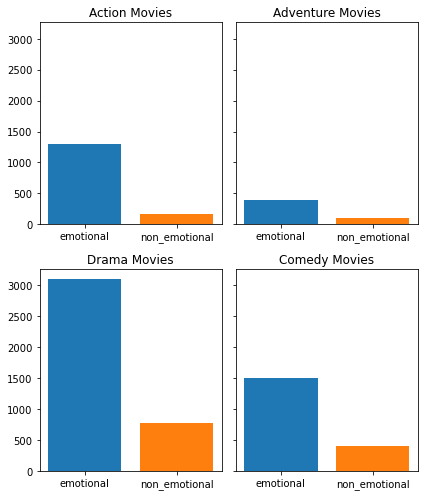

In [47]:
fig, axs = plt.subplots(2,2,figsize=(6, 7), sharey=True)
for index, dataset in enumerate(list(dataset_by_genre.keys())):  
    head =  dataset_by_genre[dataset]['movie_type'].value_counts().loc[["emotional", "non_emotional"]]
    axs[int(index/2),index%2].bar(head.index, head.values, color=["tab:blue", "tab:orange"])  
    axs[int(index/2),index%2].set_title(dataset + " Movies")
    axs[int(index/2),index%2].set(xlabel=None)
fig.tight_layout()

As can be seen from the above figure, the emotional movies are more predimonent compared to non-emotional movies. 

Text(0.0, 0.5, 'Number of Movies')

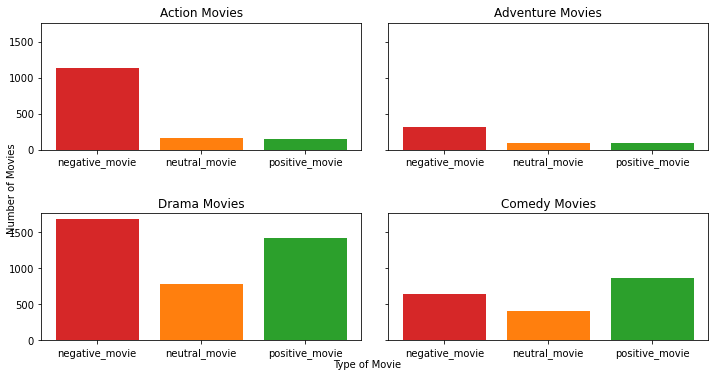

In [49]:
fig, axis = plt.subplots(2,2, figsize=(10,5), sharey=True)
fig.tight_layout() 

# visualize the distribution of the various sentiments using bar plots
for index, dataset in enumerate(list(dataset_by_genre.keys())[0:4]):
    head =  dataset_by_genre[dataset]['movie_sentiment'].value_counts().loc[["negative_movie", "neutral_movie", "positive_movie"]]
    axis[int(index/2),index%2].bar(head.index, head.values, color=["tab:red", "tab:orange", "tab:green"])
    axis[int(index/2),index%2].set_title(f"{dataset} Movies")
    
fig.subplots_adjust(hspace=0.5)
fig.text(0.5, 0.00, "Type of Movie", ha="center")
fig.text(0.0, 0.5, "Number of Movies", va="center", rotation="vertical")

As we can see from the above bar plot: <br>

(1) Negative Movies are more prevalent in Action, Drama and Adventure genres. <br>
(2) Positive Movies are more present in Comedy Movies. <br>
(3) Neutral Movies are the least prevalent in all the studied genres. <br>

With that stated, we feel that these findings suggests an explanation behind the above skewed movie counts in each genre. Since the movie business is driven by the movie success in terms of rating and profitability, are positive movies more sucessful in the comedy category compared to negative movies? Is the reverse true in the Drama, Adventure and Action Movies? <br>

We will perform a matched observational study (to deal with hidden confounds) to provide a possible explanation.  


#### Introducing and pre-processing the IMDB ratings

In our analysis, we quantify the success of the movie based on both its profitability and rating. The profitability of the movie is given by the CMU Movie Metadata dataset, while the ratings are fetched from the IMDB Dataset. The IMDB Dataset doesn't contain the freebase ID found in the CMU Movie Dataset, hence in order to join the two datasets, we use the original Title of the movie as a key. In addition to that, since the same movie can include multiple versions based on the language, we compute the average weighted sum of the ratings of all the different variations of the same movie to overall rating of the movie found in the CMU Movie dataset.  

In [22]:
#load the movie title dataset
df_name_basics = pd.read_csv('IMDB/titles.tsv', sep = '\t', low_memory =False)

In [23]:
#load the movie rating dataset
df_ratings = pd.read_csv('IMDB/ratings.tsv', sep = '\t')

In [24]:
# only choose the rows which correspond to a data of a movie
df_title = df_name_basics[df_name_basics['titleType'] == 'movie']

In [25]:
#merge the dataset with the titles and the dataset with the ratings
df_imdb = df_title.merge(df_ratings, left_on='tconst', right_on='tconst')

In [50]:
#create datasets of average ratings of a movie considering the ratings of movies with titles in different language

# get the the IMDB dataset and specifically utilize (1) original title (2) average rating (3) number of votes (4) primary title
df_imdb= df_imdb[['originalTitle', 'averageRating', 'numVotes', 'primaryTitle']] #contains all ratings for every movie
df_imdb['multiplication'] = df_imdb['averageRating']*df_imdb['numVotes']


grouped = pd.DataFrame()
grouped['sum_of_mult'] = df_imdb[['originalTitle', 'multiplication']].groupby('originalTitle').sum()
grouped['sum_of_vote'] = df_imdb[['originalTitle', 'numVotes']].groupby('originalTitle').sum()
grouped['average_rating'] = grouped['sum_of_mult']/grouped['sum_of_vote']

grouped = grouped.reset_index(level=0)
grouped.drop(['sum_of_mult'], axis =1).head()

ratings_genre_df = {"Action": pd.DataFrame(), "Adventure": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}

#average ratings for every genre
for dataset in dataset_by_genre.keys():
    ratings_genre_df[dataset] = grouped.merge(dataset_by_genre[dataset], left_on = 'originalTitle', right_on = 'Title')


In [51]:
ratings_genre_df["Action"].head(3)

,originalTitle,sum_of_mult,sum_of_vote,average_rating,id,plot,release date,Title,boxOffice,plot_classification,...,genres,number_of_sentances,language,Runtime,negative_score,neutral_score,positive_score,emotion_score,movie_sentiment,movie_type
0,10 to Midnight,52825.5,8385,6.300000,14979283,10 to Midnight is a drama that mixes elements ...,1983,10 to Midnight,7175592.0,"[0, -1, -1, -1, -1, -1, 0, 0, -1, 0]",...,"{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",10,"{""/m/02h40lc"": ""English Language""}",103.0,6,4,0,-0.355770,negative_movie,emotional
1,12 Rounds,163975.7,29272,5.601794,15169291,A sting operation to capture notorious arms de...,2009-03-19,12 Rounds,18184083.0,"[-1, 0, 1, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, -1,...",...,"{""/m/0cq22f9"": ""Action Thrillers"", ""/m/01jfsb""...",105,"{""/m/02h40lc"": ""English Language""}",108.0,32,59,14,-0.087764,neutral_movie,non_emotional
2,143,5511.2,655,8.414046,34191227,Siddu is a carefree boy-next-door. Sanjana i...,2004-08-27,143,NaN,"[1, 0, 1, 1, 0, 0, 0, -1, -1, 0]",...,"{""/m/01jfsb"": ""Thriller"", ""/m/02l7c8"": ""Romanc...",10,"{""/m/09s02"": ""Telugu language""}",143.0,2,5,3,0.002080,neutral_movie,non_emotional


#### Part 2.1: Emotional vs Non-emotional movies (ratings)

In [52]:
processed_ratings_emotional_df={}

# classify the movie and compute the average rating of the emotional movie and of the non emotional movie
for index, genre in enumerate(dataset_by_genre.keys()):
    # merge the current dataframe with the ratings dataframe
    processed_ratings_emotional_df[genre] = dataset_by_genre[genre][['id', 'movie_type', 'release date', 'country', 'genres', 'Runtime', 'language', 'emotion_score', 'movie_sentiment']].merge(ratings_genre_df[genre][['id', 'average_rating', 'sum_of_vote']], left_on='id', right_on='id')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    processed_ratings_emotional_df[genre] = processed_ratings_emotional_df[genre][processed_ratings_emotional_df[genre]['sum_of_vote'] >= 100]
    processed_ratings_emotional_df[genre].reset_index(inplace=True)

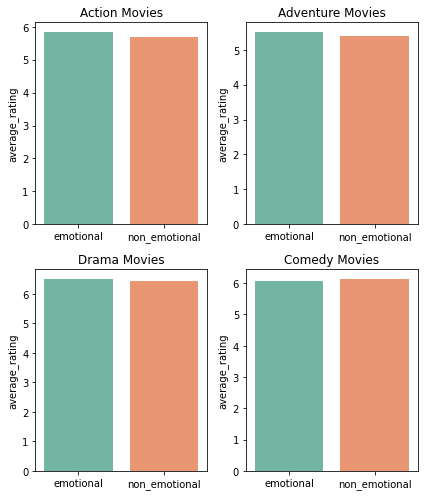

In [54]:
fig, axs = plt.subplots(2,2,figsize=(6, 7))
for index, dataset in enumerate(list(processed_ratings_emotional_df.keys())):  
    # average ratings per group
    mean_ratings_movie_type = processed_ratings_emotional_df[dataset].copy().groupby('movie_type').mean()
    mean_ratings_movie_type.reset_index(inplace=True)
    
    # sns barplot displaying the average rating per movie type (emotional vs non-emotional)
    sns.barplot(x="movie_type", y="average_rating", data=mean_ratings_movie_type, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")
    axs[int(index/2),index%2].set(xlabel=None)
fig.tight_layout()

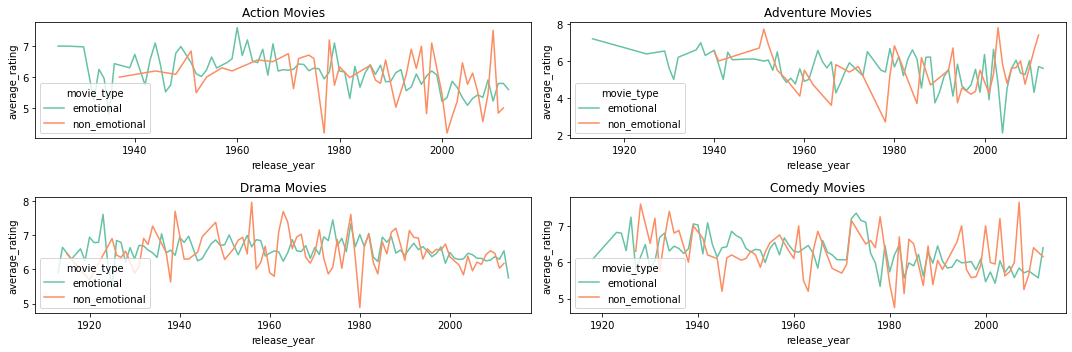

In [90]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_type', 'release_year']).mean()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="average_rating", data=mean_box_cluster, hue="movie_type",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()


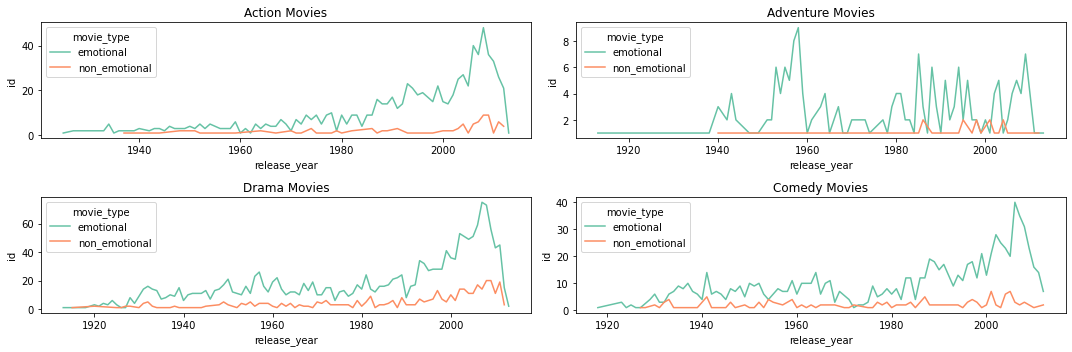

In [94]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_type', 'release_year']).count()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="id", data=mean_box_cluster, hue="movie_type",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

Now that we have classified the movies into emotional/non-emotional, we can now performed a matched study (since our data is collected from observation; real-world data). The matched study consists of matching each movie that is emotional with a movie that is not-emotional based on similar runtime and emotion score. This can remove certain confounds that can affect both (1) the success of the movie and (2) the movie being emotional or not.

In [55]:
emotional_dataset = {}
non_emotional_dataset = {}

for genre in list(processed_ratings_emotional_df.keys()):
    dataset = processed_ratings_emotional_df[genre]
    emotional_dataset[genre] = dataset[dataset["movie_type"]=="emotional"]
    non_emotional_dataset[genre] = dataset[dataset["movie_type"]=="non_emotional"]

In [56]:
# list of ids to be used to track the matches
matched_emotional_ids = defaultdict(lambda: [])
matched_non_emotional_ids = defaultdict(lambda: [])

# iterate over all genres 
for genre in list(emotional_dataset.keys()):
    for emotional_id, emotional_dataframe in emotional_dataset[genre].iterrows():
        for non_emotional_id, non_emotional_dataframe in non_emotional_dataset[genre].iterrows():
            if abs(emotional_dataframe["Runtime"] - non_emotional_dataframe["Runtime"])<20 and (abs(emotional_dataframe["emotion_score"] - abs(non_emotional_dataframe["emotion_score"])))>0.4 and non_emotional_id not in matched_non_emotional_ids[genre]:
                matched_emotional_ids[genre].append(int(emotional_id))
                matched_non_emotional_ids[genre].append(int(non_emotional_id))
                break

In [57]:
matched_dataset_per_genre = {}
for genre in list(non_emotional_dataset.keys()):
    # concatenate the two dataframes (by correctly choosing the matched rows) and for the correct genres
    matched_dataset_per_genre[genre] = pd.concat([processed_ratings_emotional_df[genre].iloc[matched_non_emotional_ids[genre]], processed_ratings_emotional_df[genre].iloc[matched_emotional_ids[genre]]])

In [58]:
for genre in matched_dataset_per_genre.keys():
    print(f"The length of matched candidates in {genre} Movies is {int(len(matched_dataset_per_genre[genre])/2)}")


The length of matched candidates in Action Movies is 85
The length of matched candidates in Adventure Movies is 36
The length of matched candidates in Drama Movies is 361
The length of matched candidates in Comedy Movies is 134


In [59]:
nbr_of_samples = 10000

# construct a N samples of size N 
def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        # sample a dataset of sie N
        indices = np.random.randint(0, len(data), len(data))

        # form the dataset
        data_tmp = data[indices] 
        
        # compute the arithmetic mean
        means[n] = np.nanmean(data_tmp)
    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)], np.mean(means)

In [62]:
emotional_movies_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

non_emotional_movie_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

pvalues_difference = {"Action" : 0, "Adventure" : 0, "Drama" : 0, "Comedy" : 0}

for genre in matched_dataset_per_genre.keys():
    # get the genre matched dataframe
    genre_dataframe = matched_dataset_per_genre[genre]

    # get the emotional movies of that genre
    emotional_data = genre_dataframe[genre_dataframe["movie_type"] == "emotional"]

    # get the non emotional movies of that genre
    non_emotional_data= genre_dataframe[genre_dataframe["movie_type"] == "non_emotional"]

    # emotional metrics
    emotional_movies_metrics[genre]["Confidence Interval"], emotional_movies_metrics[genre]["Mean"] = bootstrap_CI(emotional_data["average_rating"].values, nbr_of_samples)
    
    # non emotional metrics
    non_emotional_movie_metrics[genre]["Confidence Interval"], non_emotional_movie_metrics[genre]["Mean"] = bootstrap_CI(non_emotional_data["average_rating"].values, nbr_of_samples)
    
    # pvalues of the independant t-test
    pvalues_difference[genre] = stats.ttest_ind(emotional_data["average_rating"] , non_emotional_data["average_rating"]).pvalue

In [63]:
for genre in emotional_movies_metrics.keys() :
    print(f"In {genre} movies")
    print(f"\tThe average rating for emotional movies is {emotional_movies_metrics[genre]['Mean']} and with the confidence {emotional_movies_metrics[genre]['Confidence Interval']}")

    print(f"\tThe average rating for non-emotional movies is {non_emotional_movie_metrics[genre]['Mean']} and with the confidence {non_emotional_movie_metrics[genre]['Confidence Interval']}")

    print(f"\tThe pvalues for the non emotional and emotional movies is {pvalues_difference[genre]}\n")


In Action movies
	The average rating for emotional movies is 5.97022963266002 and with the confidence [5.75776741515163, 6.1786782637050965]
	The average rating for non-emotional movies is 5.600857062386013 and with the confidence [5.331661066769798, 5.859527387409921]
	The pvalues for the non emotional and emotional movies is 0.03575791307516097

In Adventure movies
	The average rating for emotional movies is 5.461678514123102 and with the confidence [5.119051447637083, 5.788694203308415]
	The average rating for non-emotional movies is 5.261648979044115 and with the confidence [4.907106343550301, 5.6244709888645215]
	The pvalues for the non emotional and emotional movies is 0.44397616179919286

In Drama movies
	The average rating for emotional movies is 6.47328715121928 and with the confidence [6.3741127345352915, 6.571400366848655]
	The average rating for non-emotional movies is 6.477443325699984 and with the confidence [6.375742113937308, 6.575969738396482]
	The pvalues for the non 

#### Part 2.2: Positive vs Negative movies (ratings)

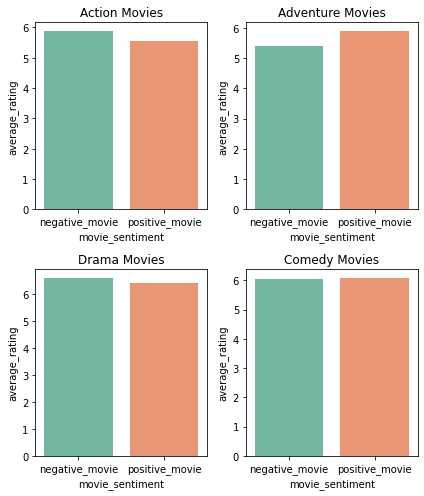

In [64]:
ratings_pn_df = dataset_by_genre.copy()
fig, axs = plt.subplots(2,2,figsize=(6, 7))

# filter the movie, we take only negative and positive movies and compute the average rating
for index, dataset in enumerate(ratings_pn_df.keys()):

    #filter the movie
    ratings_pn_df[dataset] = ratings_pn_df[dataset][(ratings_pn_df[dataset]['movie_sentiment'] == "negative_movie") | (ratings_pn_df[dataset]['movie_sentiment'] == "positive_movie")]
    ratings_pn_df[dataset] = ratings_pn_df[dataset][['id', 'movie_sentiment']].merge(ratings_genre_df[dataset][['id', 'average_rating', 'sum_of_vote']], left_on='id', right_on='id')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_pn_df[dataset] = ratings_pn_df[dataset][ratings_pn_df[dataset]['sum_of_vote'] >= 100][['movie_sentiment', 'average_rating']]
    mean_ratings_pn = ratings_pn_df[dataset].copy().groupby('movie_sentiment').mean()
    mean_ratings_pn.reset_index(inplace=True)
    sns.barplot(x="movie_sentiment", y="average_rating", data=mean_ratings_pn, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")

fig.tight_layout()

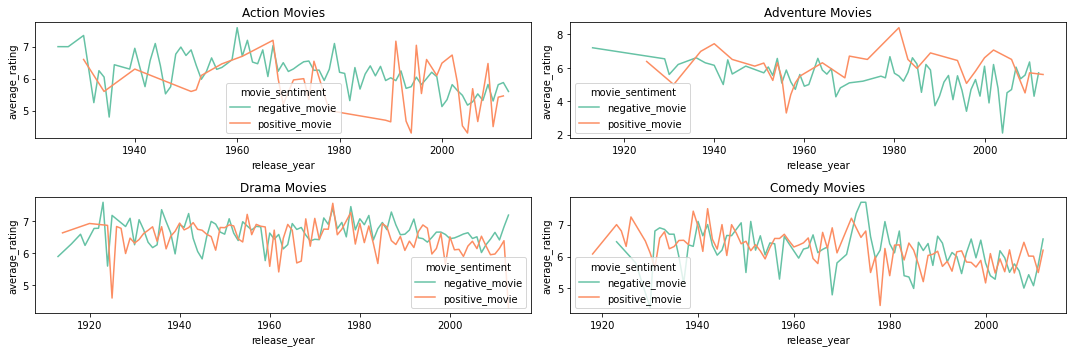

In [97]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe = genre_dataframe[genre_dataframe["movie_sentiment"].str.contains("neutral_movie") == False]
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_sentiment', 'release_year']).mean()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="average_rating", data=mean_box_cluster, hue="movie_sentiment",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

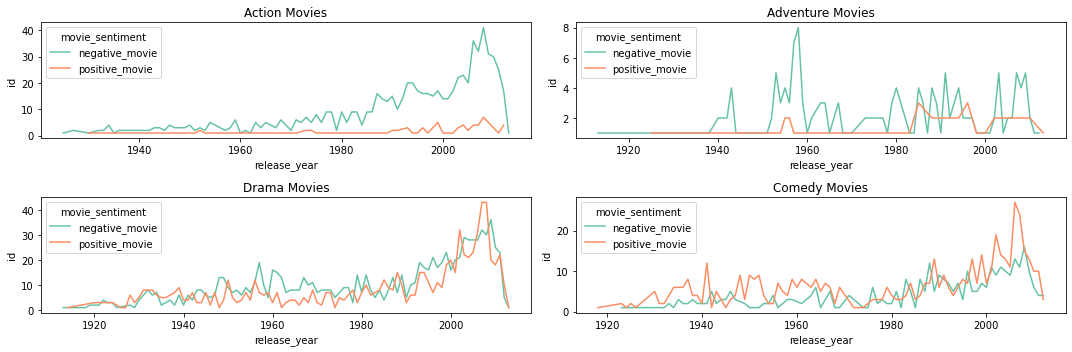

In [99]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))

for index, genre in enumerate(processed_ratings_emotional_df.keys()):
    genre_dataframe = processed_ratings_emotional_df[genre].copy()
    genre_dataframe = genre_dataframe[genre_dataframe["movie_sentiment"].str.contains("neutral_movie") == False]
    genre_dataframe["release_year"] = pd.to_datetime(genre_dataframe['release date']).dt.year
    mean_box_cluster = genre_dataframe.groupby(['movie_sentiment', 'release_year']).count()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release_year", y="id", data=mean_box_cluster, hue="movie_sentiment",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(genre + " Movies")
fig.tight_layout()

In [65]:
# create the two datasets is before and is after
positive_dataset = {}
negative_dataset = {}

for genre in list(processed_ratings_emotional_df.keys()):
    dataset = processed_ratings_emotional_df[genre]
    positive_dataset[genre] = dataset[dataset["movie_sentiment"]=="positive_movie"]
    negative_dataset[genre] = dataset[dataset["movie_sentiment"]=="negative_movie"]

In [66]:
# list of ids to be used to track the matches
matched_positive_ids = defaultdict(lambda: [])
matched_negative_ids = defaultdict(lambda: [])

# iterate over all genres 
for genre in list(positive_dataset.keys()):
    for positive_id, positive_dataframe in positive_dataset[genre].iterrows():
        for negative_id, negative_dataframe in negative_dataset[genre].iterrows():
            if abs(positive_dataframe["Runtime"] - negative_dataframe["Runtime"])<20 and (abs(positive_dataframe["emotion_score"] - abs(negative_dataframe["emotion_score"])))<0.05 and negative_id not in matched_negative_ids[genre]:
                matched_positive_ids[genre].append(int(positive_id))
                matched_negative_ids[genre].append(int(negative_id))
                break

In [67]:
matched_positive_negative_per_genre = {}
for genre in list(non_emotional_dataset.keys()):
    # concatenate the two dataframes (by correctly choosing the matched rows) and for the correct genres
    matched_positive_negative_per_genre[genre] = pd.concat([processed_ratings_emotional_df[genre].iloc[matched_positive_ids[genre]], processed_ratings_emotional_df[genre].iloc[matched_negative_ids[genre]]])

In [68]:
for genre in matched_positive_negative_per_genre.keys():
    print(f"The length of matched candidates in {genre} Movies is {int(len(matched_positive_negative_per_genre[genre])/2)}")

The length of matched candidates in Action Movies is 50
The length of matched candidates in Adventure Movies is 34
The length of matched candidates in Drama Movies is 707
The length of matched candidates in Comedy Movies is 345


In [69]:
positive_movies_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                            "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

negative_movie_metrics = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Drama" : {"Mean" : 0, "Confidence Interval" : []}, 
                               "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}

pvalues_difference = {"Action" : 0, "Adventure" : 0, "Drama" : 0, "Comedy" : 0}

for genre in matched_positive_negative_per_genre.keys():
    # get the genre matched dataframe
    genre_dataframe = matched_positive_negative_per_genre[genre]

    # get the emotional movies of that genre
    positive_data = genre_dataframe[genre_dataframe["movie_sentiment"] == "positive_movie"]

    # get the non emotional movies of that genre
    negative_data= genre_dataframe[genre_dataframe["movie_sentiment"] == "negative_movie"]

    # emotional metrics
    positive_movies_metrics[genre]["Confidence Interval"], positive_movies_metrics[genre]["Mean"] = bootstrap_CI(positive_data["average_rating"].values, nbr_of_samples)
    
    # non emotional metrics
    negative_movie_metrics[genre]["Confidence Interval"], negative_movie_metrics[genre]["Mean"] = bootstrap_CI(negative_data["average_rating"].values, nbr_of_samples)
    
    # pvalues of the independant t-test
    pvalues_difference[genre] = stats.ttest_ind(positive_data["average_rating"] , negative_data["average_rating"]).pvalue

In [70]:
for genre in matched_positive_negative_per_genre.keys() :
    print(f"In {genre} movies")
    print(f"\tThe average rating for positive movies is {positive_movies_metrics[genre]['Mean']} and with the confidence {positive_movies_metrics[genre]['Confidence Interval']}")

    print(f"\tThe average rating for negative movies is {negative_movie_metrics[genre]['Mean']} and with the confidence {negative_movie_metrics[genre]['Confidence Interval']}")

    print(f"\tThe pvalues for the positive and negative movies is {pvalues_difference[genre]}\n")

In Action movies
	The average rating for positive movies is 5.360561845155558 and with the confidence [5.032067191291213, 5.6855920568378915]
	The average rating for negative movies is 5.932906299253075 and with the confidence [5.630237411676217, 6.219387035305251]
	The pvalues for the positive and negative movies is 0.013727675803219267

In Adventure movies
	The average rating for positive movies is 5.920308700772625 and with the confidence [5.435053138730473, 6.385165663196304]
	The average rating for negative movies is 5.3505725999972595 and with the confidence [4.9608457278056, 5.721949542158293]
	The pvalues for the positive and negative movies is 0.07383961108628512

In Drama movies
	The average rating for positive movies is 6.433492947239276 and with the confidence [6.358962139189526, 6.505007251233791]
	The average rating for negative movies is 6.637442325593649 and with the confidence [6.571974047508052, 6.702893844680804]
	The pvalues for the positive and negative movies is 4

#### Part 2.3: Most profitable movie arc per genre (box office)

In this section, we build the dataframes to analyze the profitability of the movie arcs. In order to do so, we utilize the boxOffice revenues.

In [ ]:
#Standartization of boxOffice
boxOffice_df = processed_df.copy()
boxOffice_df.dropna(subset='boxOffice', inplace=True)
boxOffice_df['country'] = boxOffice_df['country'].apply(lambda d: list(json.loads(d).values()))
boxOffice_df['one'] = boxOffice_df['country'].apply(lambda d: len(d)==1)
boxOffice_df = boxOffice_df[boxOffice_df['one'] ]
boxOffice_df.drop(['one'], axis = 1, inplace=True)
boxOffice_df['country'] = boxOffice_df['country'].apply(lambda d: d[0])

#Standartization the boxOffice by country
m_df= boxOffice_df.drop(['boxOffice'], axis=1)
m_df = boxOffice_df[['country', 'boxOffice']].groupby('country').transform(lambda x: (x - x.mean()) / x.std()).join(m_df)
m_df.dropna(subset=['boxOffice'], inplace=True)
m_df = m_df[['id', 'boxOffice']]
m_df.shape[0]

In [ ]:
m_df.head()

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(15, 5))
norm_df = {"Action": pd.DataFrame(), "Adventure": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}

# draw the average of boxOffice by year for each cluster of each movie genre
for index, dataset in enumerate(dataset_by_genre.keys()):
    norm_df[dataset] = dataset_by_genre[dataset].drop(['boxOffice'], axis=1).merge(m_df, left_on='id', right_on='id')

    # transform the release date into year date
    norm_df[dataset]['release date'] = pd.to_datetime(norm_df[dataset]['release date'])
    norm_df[dataset]['release date'] = norm_df[dataset]['release date'].dt.year
    print(norm_df[dataset].shape[0])
    norm_df[dataset].dropna(subset=['release date'],  inplace=True)
    print(norm_df[dataset].shape[0])
    
    # Compute the average of boxOffice by year and by cluster
    norm_df[dataset] = norm_df[dataset][['cluster_id', 'release date', 'boxOffice']]
    mean_box_cluster = norm_df[dataset].copy().groupby(['cluster_id', 'release date']).mean()
    mean_box_cluster.reset_index(inplace=True)
    sns.lineplot(x="release date", y="boxOffice", data=mean_box_cluster, hue="cluster_id",  palette="Set2", ax=axs[int(index/2),index%2])
    axs[int(index/2),index%2].set_title(dataset + " Movies")

fig.tight_layout()

We can clearly observe the varitation of the boxOffice revenue over time for each movie arc cluster. In Milestone 3, we will check whether a significant variation exist by (1) displaying the error plots and (2) performing heterogeneity tests.

In [ ]:
quartile_df = norm_df.copy()
init_map = {"MeanCluster0" : 0, "Confidence_IntervalCluster0" : [], "MeanCluster1" : 0, "Confidence_IntervalCluster1" : [], "pvalue" : 0}
init_list = [init_map.copy(), init_map.copy(), init_map.copy(), init_map.copy()]
quartile_map = {"Action" : init_list.copy(), "Adventure" : init_list.copy(), "Drama" : init_list.copy(), "Comedy" : init_list.copy()}
fig = plt.figure(figsize = (16,16), constrained_layout=True)
subfigs = fig.subfigures(nrows=4, ncols=1, hspace=10.0, wspace=0.07)
for dataset in zip(norm_df.keys(), subfigs) :
    quartile_df[dataset[0]]["quartile"] = pd.qcut(quartile_df[dataset[0]]["release date"], q = 4, labels=False)
    dataset[1].suptitle(f"{dataset[0]} Movies", y = 1.0)
    axs = dataset[1].subplots(nrows=1, ncols=4, sharex=True, sharey=True)
    for i in range(4) :
        qi_df = quartile_df[dataset[0]][quartile_df[dataset[0]]["quartile"] == i][['cluster_id', 'boxOffice', 'release date']]
        minYear= qi_df['release date'].min()
        maxYear = qi_df['release date'].max()
        qi_cluster0 = qi_df[qi_df["cluster_id"] == 0][['boxOffice']]
        qi_cluster1 = qi_df[qi_df["cluster_id"] == 1][['boxOffice']]
        quartile_map[dataset[0]][i]["Confidence_IntervalCluster0"], quartile_map[dataset[0]][i]["MeanCluster0"] = bootstrap_CI(qi_cluster0, nbr_of_samples)
        quartile_map[dataset[0]][i]["Confidence_IntervalCluster1"], quartile_map[dataset[0]][i]["MeanCluster1"] = bootstrap_CI(qi_cluster1, nbr_of_samples)
        quartile_map[dataset[0]][i]["pvalue"] = stats.ttest_ind(qi_cluster0, qi_cluster1).pvalue
        mean_boxOffice_cluster = qi_df.copy()[['cluster_id', 'boxOffice']].groupby('cluster_id').mean()
        mean_boxOffice_cluster.reset_index(inplace=True)
        sns.barplot(x="cluster_id", y="boxOffice", data=mean_boxOffice_cluster, ax=axs[i], palette="Set2")
        axs[i].set_title(f"Q{i} [{minYear}, {maxYear}]")

        
fig.supxlabel('Cluster')
fig.supylabel('Average normalized BoxOffice')
fig.subplots_adjust(hspace=10.5)
        
        

In [ ]:

def printStats(dataset) :
    print(f"In {dataset} Movies : ")
    for i in range(4) :
        print(f"In the period defined by the quartile {i} : ")
        m = quartile_map[dataset][i]["MeanCluster0"]
        print(f"The average normalized boxOffice in the cluster 0 is {m}")
        ci = quartile_map[dataset][i]["Confidence_IntervalCluster0"]
        print(f"The confidence interval in the cluster 0 is {ci}")
        m = quartile_map[dataset][i]["MeanCluster1"]
        print(f"The average normalized boxOffice in the cluster 1 is {m}")
        ci = quartile_map[dataset][i]["Confidence_IntervalCluster1"]
        print(f"The confidence interval in the cluster 1 is {ci}")
        p = quartile_map[dataset][i]["pvalue"]
        print(f"The pvalue between this 2 clusters is {p}")

In [ ]:
printStats("Action")

In [ ]:
printStats("Adventure")

In [ ]:
printStats("Drama")

In [ ]:
printStats("Comedy")

#### Part 2.4: Most rated movie arc per genre (ratings)

In [ ]:
ratings_cluster_df = {"Action": pd.DataFrame(), "Adventure": pd.DataFrame(), "Drama":pd.DataFrame(), "Comedy":pd.DataFrame()}
fig, axs = plt.subplots(2,2, figsize=(6, 7))

#Compute the average rating for each cluster of each movie genre
for index, dataset in enumerate(dataset_by_genre.keys()):
    ratings_cluster_df[dataset] = grouped.merge(dataset_by_genre[dataset], left_on = 'originalTitle', right_on = 'Title')
    
    #take only the ratings if there is at least 100 voters and compute average of rating
    ratings_cluster_df[dataset] = ratings_cluster_df[dataset][ratings_cluster_df[dataset]['sum_of_vote'] >= 100][['cluster_id', 'average_rating']]
    mean_ratings_cluster = ratings_cluster_df[dataset].copy().groupby('cluster_id').mean()
    mean_ratings_cluster.reset_index(inplace=True)
    sns.barplot(x="cluster_id", y="average_rating", data=mean_ratings_cluster, ax=axs[int(index/2),index%2], palette="Set2")
    axs[int(index/2),index%2].set_title(dataset + " Movies")

fig.tight_layout()


Now we can observe the average of the ratings for each movie arc cluster. In Milestone 3, we analyze the displayed plots and perform significance tests to rank the different movie arc clusters present.

In [ ]:
cluster0_movies = ratings_cluster_df.copy()
cluster1_movies = ratings_cluster_df.copy()
cluster0_mc = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, "Drama" : {"Mean" : 0, "Confidence Interval" : []}, "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}
cluster1_mc = {"Action" : {"Mean" : 0, "Confidence Interval" : []}, "Adventure" : {"Mean" : 0, "Confidence Interval" : []}, "Drama" : {"Mean" : 0, "Confidence Interval" : []}, "Comedy" : {"Mean" : 0, "Confidence Interval" : []}}
pvalues_cluster01 = {"Action" : 0, "Adventure" : 0, "Drama" : 0, "Comedy" : 0}
for dataset in emo_movies.keys() :
    cluster0_movies[dataset] = cluster0_movies[dataset][cluster0_movies[dataset]["cluster_id"] == 0]
    cluster1_movies[dataset] = cluster1_movies[dataset][cluster1_movies[dataset]["cluster_id"] == 1]
    cluster0_mc[dataset]["Confidence Interval"], cluster0_mc[dataset]["Mean"] = bootstrap_CI(cluster0_movies[dataset]["average_rating"], nbr_of_samples)
    cluster1_mc[dataset]["Confidence Interval"], cluster1_mc[dataset]["Mean"] = bootstrap_CI(cluster1_movies[dataset]["average_rating"], nbr_of_samples)
    pvalues_cluster01[dataset] = stats.ttest_ind(cluster0_movies[dataset]["average_rating"] , cluster1_movies[dataset]["average_rating"]).pvalue

In [ ]:
for dataset in cluster0_movies.keys() :
    print(f"In {dataset} movies : ")
    ci = cluster0_mc[dataset]["Confidence Interval"]
    print(f"For Positive movies the confidence interval is {ci}")
    ci = cluster1_mc[dataset]["Confidence Interval"]
    print(f"For Negative movies the confidence interval is {ci}")
    print(f"The pvalues for the negative and positive movies is {pvalues_cluster01[dataset]}")